# A Quick Demo of Andrej Karpathy's minGPT Play Char Demo 

**Our Goal**: Generate Shakesperean text
- You can find the original Play Char demo in the minGPT repo here: https://github.com/karpathy/minGPT
- This notebook is partially based on the fastai Transformers tutorial: http://docs.fast.ai/tutorial.transformers

In [1]:
# For Colab
# !pip install fastai --upgrade
# !git clone https://github.com/karpathy/minGPT
# !pip install snakeviz

In [2]:
from fastai.text.all import *
from minGPT.mingpt.model import GPT, GPTConfig, GPT1Config

Download the raw text file

In [3]:
#!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

Read it in

In [4]:
raw_text = open('input.txt', 'r').read()
raw_text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

## Data Loaders

We re-implement Karpathy's `CharDataset` as a fastai Transform, which will then be passed to a dataloader

In [5]:
class CharTransform(DisplayedTransform):
    def __init__(self, data, block_size):
        self.cat = Categorize()
        self.block_size = block_size + 1
        self.data = data
        
    def setups(self, items=None):
        self.data_len = len(self.data)
        self.cat.setup(L(*self.data))
        self.itos = self.cat.vocab
        self.stoi = self.itos.items.val2idx()
        print(f'data has {self.data_len} characters, {len(self.itos)} unique.')
        self.n_sequences = math.ceil(self.data_len / (self.block_size))
        self.idxs = L(np.random.randint(0, self.data_len - (self.block_size), self.n_sequences).tolist())

    def encodes(self, o):
        chunk = self.data[self.idxs[o]:self.idxs[o]+self.block_size]
        return tensor([self.stoi[s] for s in chunk])

    def decodes(self, o): return TitledStr(''.join([self.itos[s.item()] for s in o]))

We define out block_size and n_samples (which is the number of batches in a single epoch)

**Note**:
- Note `block_size` in Karpathy's code is equivalent to `Sequence Length` in fastai
- We do not specify a validation set here as Karpathy does not in their notebook. Therefore we set `split_idx=0` in `TfmdLists`

In [6]:
block_size=128
n_sequences = math.ceil(len(raw_text) / (block_size+1)); n_sequences

8647

And we test our transform quickly

In [7]:
t = CharTransform(data=raw_text, block_size=block_size)
t.setups()

data has 1115394 characters, 65 unique.


Now we add our Transform to a `Dataset`, read more about fastai's `Dataset` [here](https://docs.fast.ai/data.core#Datasets)

In [8]:
dset = Datasets(L(range(n_sequences)), tfms=[CharTransform(raw_text, block_size)], dl_type=LMDataLoader)

data has 1115394 characters, 65 unique.


We will use an `LMDataLoader` since we have a language modeling problem, meaning it is designed to be used when trying to predict the next character/token.

Lets have a look at the first item in our dataset

In [9]:
dset[0]

(tensor([39, 52,  1, 46, 39, 47, 56,  0, 14, 43, 58, 47, 42,  1, 58, 53,  1, 39,
         52, 63,  1, 41, 56, 43, 39, 58, 59, 56, 43,  1, 47, 52,  1, 58, 46, 43,
          1, 60, 43, 57, 57, 43, 50,  0, 35, 46, 47, 41, 46,  1, 58, 46, 53, 59,
          1, 46, 43, 39, 56, 42,  5, 57, 58,  1, 41, 56, 63,  6,  1, 61, 46, 47,
         41, 46,  1, 58, 46, 53, 59,  1, 57, 39, 61,  5, 57, 58,  1, 57, 47, 52,
         49,  8,  1, 31, 47, 58,  1, 42, 53, 61, 52, 11,  0, 18, 53, 56,  1, 58,
         46, 53, 59,  1, 51, 59, 57, 58,  1, 52, 53, 61,  1, 49, 52, 53, 61,  1,
         44, 39, 56]),)

And what the original text for this first item was:

In [10]:
show_at(dset.train, 0)

an hair
Betid to any creature in the vessel
Which thou heard'st cry, which thou saw'st sink. Sit down;
For thou must now know far


The fastai library expects the data to be assembled in a `DataLoaders` object (something that has a training and validation dataloader). We can get one by using the `dataloaders` method. We just have to specify a batch size and a sequence length. 

To further optimize the `LMDataLoader` initialisation, we pass a list of item lengths. As each item is already `block_size + 1` digits long we don't need to re-calculate the actual length for each item.

In [11]:
bs = 256
lens = [block_size+1 for i in range(len(dset.train))]
dls = dset.dataloaders(bs=bs, seq_len=block_size, lens=lens)

We can inspect a single batch by uncommenting the below line:

In [12]:
#o = dls.one_batch(); len(o), o[0].size(), o[1].size(), o

And we can also inspect what a single batch looks like

In [13]:
dls.show_batch(max_n=2)

,text,text_
0,"That's by me wounded: both our remedies\nWithin thy help and holy physic lies:\nI bear no hatred, blessed man, for, lo,\nMy interce","hat's by me wounded: both our remedies\nWithin thy help and holy physic lies:\nI bear no hatred, blessed man, for, lo,\nMy interces"
1,"e than it is ere foul sin gatnt this morning.\n\nKING RICHARD III:\n\nMessenger:\nMy lord, he doth deny to come.\n\nKING RICHARD III:\nO","than it is ere foul sin gatnt this morning.\n\nKING RICHARD III:\n\nMessenger:\nMy lord, he doth deny to come.\n\nKING RICHARD III:\nOf"


## Callback to Grab First Output

We only need the logits from the model, however Karpathy's GPT model actually also calculates and returns the loss in the forward pass, `(logits, loss)`.  So we need to write the event `after_pred` and replace `self.learn.pred` (which contains the predictions that will be passed to the loss function) by just its first element. 

In [14]:
class DropLoss(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

## GPT Model

I had to use 6 layers instead of 8 as my 2080 GPU has 13GB of ram

In [15]:
mconf = GPTConfig(vocab_size=len(dls.itos), block_size=block_size, n_layer=6, n_head=8, n_embd=512)
model = GPT(mconf)

## Learner

We pass our dataloader and model to a `Learner` and adjust the Adam's hyperparameters to match Karpathy's

In [16]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                opt_func=partial(Adam, sqr_mom=0.95, wd=0.1), cbs=[DropLoss]).to_fp16()

/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.2089296132326126)

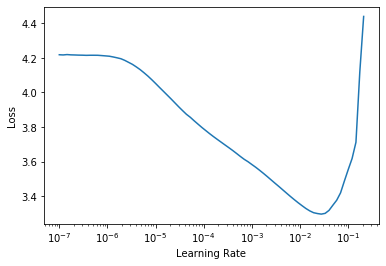

In [17]:
learn.lr_find()

Start a training loop

*(Scroll past learner output to see an example of the output text the model can generate)*

In [ ]:
learn.fit_one_cycle(150, 6e-4)    

epoch,train_loss,valid_loss,time
0,4.194919,None,00:08
1,3.843096,None,00:08
2,3.637763,None,00:08
3,3.525806,None,00:08
4,3.435995,None,00:08
5,3.453174,None,00:08
6,3.404909,None,00:08
7,3.433453,None,00:08
8,3.390314,None,00:08
9,3.391572,None,00:08


/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.recorder.plot_sched()

Note there is no validation loss or validation perplexity as we we didn't specify a validation set (as per Karpathy's notebook)

In [ ]:
from minGPT.mingpt.utils import sample

context = "O God, O God!"
x = torch.tensor([dls.char_transform.stoi[s] for s in context], dtype=torch.long)[None,...].to(dls.device)
y = sample(model, x, 2000, temperature=0.9, sample=True, top_k=5)[0]
completion = ''.join([dls.char_transform.itos[int(i)] for i in y])
print(completion)